In [2]:
import urllib3
urllib3.disable_warnings()

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Convolution2D, ReLU, MaxPooling2D

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, InputLayer

import numpy as np
import librosa
import librosa.display
import os
import pandas as pd
import ast
from tqdm import tqdm
from pathlib import Path
from IPython.display import Audio, display, Image, YouTubeVideo
from sklearn.model_selection import train_test_split
import random 

# Load the TensorBoard notebook extension
%load_ext tensorboard

print(tf.__version__)

2.2.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/My Drive"

fma_small  tracks.csv


# Music Genre Recognition

## 1. Loading data

https://github.com/mdeff/fma

In [0]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        
        for column in tqdm(COLUMNS, desc='Loading tracks...'):
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        
        for column in tqdm(COLUMNS, desc='Loading tracks...'):
            tracks[column] = pd.to_datetime(tracks[column])

        # SUBSETS = ('small', 'medium', 'large')
        # tracks['set', 'subset'] = tracks['set', 'subset'].astype(
        #         'category', categories=SUBSETS, ordered=True)

        COLUMNS = [('track', 'license'), ('artist', 'bio'),
                   ('album', 'type'), ('album', 'information')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [6]:
%%time
metadata_path = "/content/drive/My Drive/tracks.csv"
tracks_metadata = load(metadata_path) 

Loading tracks...: 100%|██████████| 7/7 [00:00<00:00, 16.77it/s]


CPU times: user 7.84 s, sys: 336 ms, total: 8.17 s
Wall time: 14.3 s


In [7]:
tracks_metadata['track'].head()

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [8]:
tracks_metadata['album'].head()

,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


In [9]:
tracks_metadata['artist'].head()

,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


In [10]:
tracks_metadata['set'].head()

,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


In [0]:
audio_path = "/content/drive/My Drive/fma_small"
audio_folders = os.listdir(audio_path)[2:]

In [0]:
AUDIO_PATHS = []

for folder in audio_folders:
    audio = os.listdir(audio_path +'/'+ folder)
    for a in audio:
        AUDIO_PATHS.append(audio_path +'/'+ folder + '/' + a)

In [13]:
print(f'All audio: {len(AUDIO_PATHS)}')

All audio: 8000


## 2. Converting audio data into mel-spectogram

In [14]:
filename = os.fspath(AUDIO_PATHS[0])

y, sr = librosa.load(filename, sr=None, mono=True)
# trim silent edges
song, _ = librosa.effects.trim(y)
Audio(data=song, rate=sr)

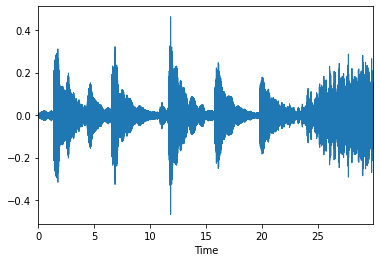

In [15]:
librosa.display.waveplot(song, sr=sr)

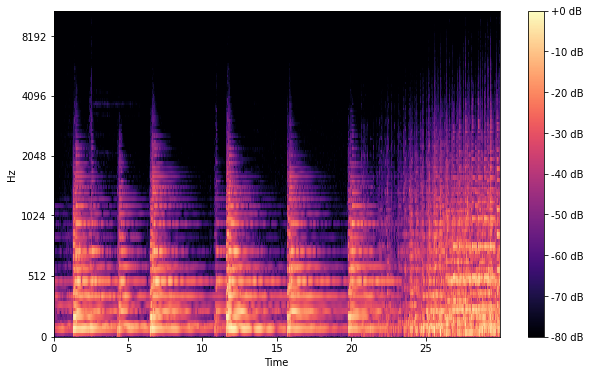

In [16]:
n_fft = 2048
hop_length = 512
n_mels = 128

S = librosa.feature.melspectrogram(song, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 6));
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [0]:
def mel_spectogram(path):
  y, sr = librosa.load(path, sr=None, mono=True)
  song, _ = librosa.effects.trim(y)
  S = librosa.feature.melspectrogram(song, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  S_DB = librosa.power_to_db(S, ref=np.max)
  return S_DB

## 3. Prepare datasets

In [0]:
def get_track_id(path):
  return int(path.split('/')[-1].split('.')[0])

def get_target(i, PATHS):
  id = get_track_id(PATHS[i])
  return np.array(tracks_metadata['track'].loc[id][['genre_top']])[0]

In [0]:
# take only 1000 / 8000 of audio files, because creating mel-spectograms takes 
# over 3h ...

AUDIO_PATHS_cut = random.sample(AUDIO_PATHS, 1000)

In [20]:
%%time

targets = []
for i in tqdm(range(len(AUDIO_PATHS_cut)), desc='Getting targets...'):
  targets.append(get_target(i, PATHS=AUDIO_PATHS_cut))

Getting targets...: 100%|██████████| 1000/1000 [00:23<00:00, 41.92it/s]

CPU times: user 23 s, sys: 896 ms, total: 23.9 s
Wall time: 23.9 s


In [21]:
# in case X is saved
%%time
X = np.load('/content/x.txt.npy')

CPU times: user 13.3 ms, sys: 1.58 s, total: 1.59 s
Wall time: 1min 15s


In [20]:
X = []
for path in tqdm(AUDIO_PATHS_cut, desc='Creating mel-spectograms...'):
    X.append(mel_spectogram(path))

Creating mel-spectograms...: 100%|██████████| 1000/1000 [21:08<00:00,  1.27s/it]


In [0]:
# reshape spectograms to equal size

mx = max([x.shape[1] for x in X])

for i in range(len(X)):
    s = X[i].shape
    diff = (mx - s[1]) * s[0]
    X[i] = np.concatenate((np.zeros(diff) , X[i].reshape(-1))).reshape(s[0], -1)

In [0]:
X = np.array(X)

In [23]:
# save X to avoid computing everything again, when colab crushes ...
np.save('x.txt', X)

(1000, 128, 2812)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, targets, test_size=0.33, random_state=42)

In [25]:
X_train.shape, X_test.shape

((670, 128, 2812), (330, 128, 2812))

In [26]:
audio_shape = X_train[0].shape
audio_shape

(128, 2812)

In [27]:
classes = np.unique(y_train)
class_number = len(classes)
classes

array(['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental',
       'International', 'Pop', 'Rock'], dtype='<U13')

In [0]:
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

In [0]:
a, b, c, d = X_train.shape
X_train = X_train.reshape((a, c, d, 1))

a, b, c, d = X_test.shape
X_test = X_test.reshape((a, c, d, 1))

In [30]:
X_train.shape, X_test.shape

((670, 128, 2812, 1), (330, 128, 2812, 1))

In [0]:
class_to_num = {
    'Electronic' : 0, 
    'Experimental' : 1, 
    'Folk' : 2, 
    'Hip-Hop' : 3, 
    'Instrumental' : 4,
    'International' : 5, 
    'Pop' : 6,
    'Rock' : 7
}

In [0]:
y_train = np.array(list(map(lambda x: class_to_num[x], y_train)))
y_test = np.array(list(map(lambda x: class_to_num[x], y_test)))

## 4. Simple dense model

In [0]:
model_mlp1 = tf.keras.Sequential([
    Flatten(input_shape=(audio_shape + (1, ))),
    Dense(1000, activation='relu'),
    Dense(500, activation='relu'),
    Dense(class_number),
])


model_mlp1.summary()


model_mlp1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
tensorboard = TensorBoard('logs/mlp-model1')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, patience=3)
model_checkpoint = ModelCheckpoint('check_points/model_mlp1.h5', save_best_only=True)

model_mlp1.fit(
    X_train, y_train, epochs=50, validation_data=(X_test, y_test),
    callbacks=[early_stopping, tensorboard, reduce_lr, model_checkpoint]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 359936)            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              359937000 
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4008      
Total params: 360,441,508
Trainable params: 360,441,508
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
21/21 [==============================] - 2s 114ms/step - loss: 41083.5625 - accuracy: 0.1269 - val_loss: 13438.8740 - val_accuracy: 0.1212 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 2s 101ms/step - loss: 891

## 4. CNN model

In [30]:
model_cnn = tf.keras.Sequential([
    Convolution2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', input_shape=audio_shape + (1, )),
    MaxPooling2D((2, 2)),
    Convolution2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    Flatten(),
    Dense(16, activation='tanh'),
    Dense(class_number)
])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 2812, 16)     160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 1406, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 1404, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 702, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 702, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 696384)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                1

In [31]:
model_cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
tensorboard = TensorBoard('logs/cnn-model')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, patience=3)
model_checkpoint = ModelCheckpoint('check_points/cnn-model.h5', save_best_only=True)

model_cnn.fit(
    X_train, epochs=50, validation_data=y_train,
    callbacks=[early_stopping, tensorboard, reduce_lr, model_checkpoint]
)

Epoch 1/50


ValueError: ignored

## 5. RNN model

## 6. Convolutional Recurrent Model

https://arxiv.org/pdf/1609.04243.pdf

![](https://i.imgur.com/VgekWM5.png)


In [0]:
TODO

## 7. Parallel CNN-RNN Model

https://arxiv.org/abs/1712.08370

![](https://i.imgur.com/2eZuliH.png)

In [0]:
TODO